In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
import numpy as np
from load_data_and_distribution_analisys import load_dataset_cleaned, split_dataset_v1, plot_confusion_matrix
import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [3]:
dataset = load_dataset_cleaned()

Path to dataset files: /Users/marcodeano/.cache/kagglehub/datasets/sooyoungher/smoking-drinking-dataset/versions/2
   sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0    1   35     170      75       90.0         1.0          1.0        1.0   
1    1   30     180      80       89.0         0.9          1.2        1.0   
2    1   40     165      75       91.0         1.2          1.5        1.0   
3    1   50     175      80       91.0         1.5          1.2        1.0   
4    1   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  LDL_chole  triglyceride  hemoglobin  urine_protein  \
0         1.0  120.0  ...      126.0          92.0        17.1            1.0   
1         1.0  130.0  ...      148.0         121.0        15.8            1.0   
2         1.0  120.0  ...       74.0         104.0        15.8            1.0   
3         1.0  145.0  ...      104.0         106.0        17.6            1.0   
4         1

In [4]:
X_smoke, y_smoke, X_drink, y_drink = split_dataset_v1(dataset)

In [5]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smoke, y_smoke, test_size=0.4, random_state=42)
print(X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape)

(591043, 22) (394030, 22) (591043,) (394030,)


In [6]:
y_train_binary_s = np.where(y_train_s == 1, 0, 1)  # 0 = NON FUMATORE, 1 = EX FUMATORE o FUMATORE
y_test_binary_s = np.where(y_test_s == 1, 0, 1) 

In [7]:
model = {
    "svc": Pipeline([("scaler", StandardScaler()), ("svc", LinearSVC(random_state=42, class_weight='balanced'))]),
    "knn": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=500, n_jobs=-1))]),
    "rf": Pipeline([("random_forest", RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=50, random_state=42, class_weight='balanced', n_jobs=-1))]),
    "adaboost": Pipeline([("adaboost", AdaBoostClassifier(n_estimators=100, random_state=42))])
}

In [8]:
estimators = [
    ('svc', model["svc"]),
    ('rf', model["rf"]),
    ('knn', model["knn"]),
    ('adaboost', model["adaboost"])
]

stacking = StackingClassifier(estimators=estimators, final_estimator=LinearSVC(), n_jobs=-1, cv=2)

In [9]:
stacking.fit(X_train_s, y_train_binary_s)

/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=2,
                   estimators=[('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                                 LinearSVC(class_weight='balanced',
                                                           random_state=42))])),
                               ('rf',
                                Pipeline(steps=[('random_forest',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=50,
                                                                        min_samples_split=50,
                                                                        n_jobs=-1,
                                                                        random_state=42))])),
                               ('knn',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('knn',
                                                 KNeighborsClassifier(n_jobs=-1,
                                                                      n_neighbors=500))])),
                               ('adaboost',
                                Pipeline(steps=[('adaboost',
                                                 AdaBoostClassifier(n_estimators=100,
                                                                    random_state=42))]))],
                   final_estimator=LinearSVC(), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.93      0.74      0.83    239845
           1       0.70      0.91      0.79    154185

    accuracy                           0.81    394030
   macro avg       0.81      0.83      0.81    394030
weighted avg       0.84      0.81      0.81    394030



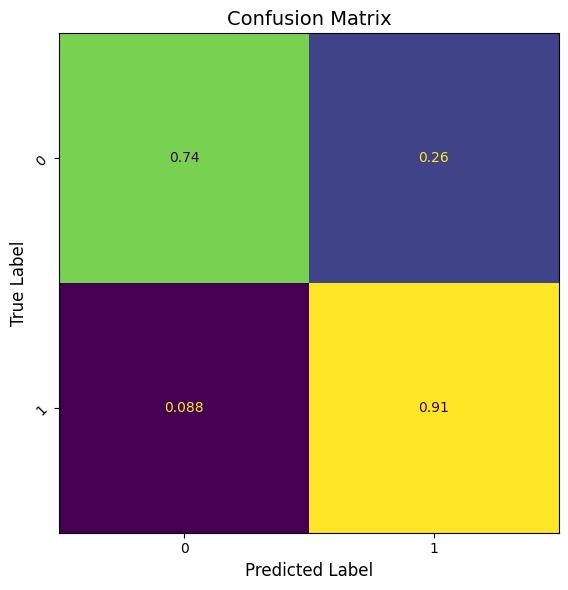

In [11]:
y_pred_s = stacking.predict(X_test_s)

report = classification_report(y_test_binary_s, y_pred_s)
print(report)
plot_confusion_matrix(y_test_binary_s, y_pred_s, stacking.classes_, "Confusion Matrix", cmap='viridis')

In [12]:
idx = np.where(y_test_s == 2)[0]
X_ex_smoke = X_test_s.iloc[idx]
y_ex_smoke = y_test_s.iloc[idx]
print(X_ex_smoke.shape, y_ex_smoke.shape)

idx = np.where(y_test_s == 3)[0]
X_actual_smoke = X_test_s.iloc[idx]
y_actual_smoke = y_test_s.iloc[idx]
print(X_actual_smoke.shape, y_actual_smoke.shape)

X_smoke = pd.concat([X_ex_smoke, X_actual_smoke])
y_smoke = np.concatenate((y_ex_smoke, y_actual_smoke))
print(X_smoke.shape, y_smoke.shape)

(69420, 22) (69420,)
(84765, 22) (84765,)
(154185, 22) (154185,)


In [13]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smoke, y_smoke, test_size=0.4, random_state=42)
print(X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape)

(92511, 22) (61674, 22) (92511,) (61674,)


In [14]:
pipelines = {
    "forest": Pipeline([("forest", RandomForestClassifier(random_state=42, max_depth=20, min_samples_split=50, n_estimators=100, class_weight="balanced"))]),
    "adaboost": Pipeline([("adaboost", AdaBoostClassifier(n_estimators=200, random_state=42))]),
    "svm": Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC(random_state=42, C=0.1, class_weight="balanced"))]),
    "knn": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=500, n_jobs=-1))]),
}

In [15]:
for name, pipeline in pipelines.items():
    print(f"Training {name}...", end=" ")
    t0 = time.time()

    pipeline.fit(X_train_s, y_train_s)  
    
    print(f"took {time.time() - t0:.2f} seconds")

Training forest... took 9.01 seconds
Training adaboost... 

/Users/marcodeano/venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


took 10.32 seconds
Training svm... took 0.16 seconds
Training knn... took 0.01 seconds


Classification report per forest:
              precision    recall  f1-score   support

         2.0       0.62      0.60      0.61     27698
         3.0       0.68      0.70      0.69     33976

    accuracy                           0.66     61674
   macro avg       0.65      0.65      0.65     61674
weighted avg       0.66      0.66      0.66     61674



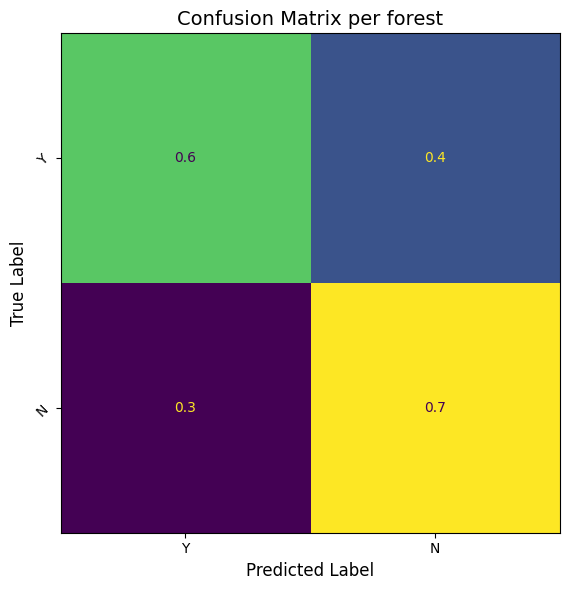

Classification report per adaboost:
              precision    recall  f1-score   support

         2.0       0.64      0.54      0.59     27698
         3.0       0.67      0.75      0.71     33976

    accuracy                           0.66     61674
   macro avg       0.65      0.65      0.65     61674
weighted avg       0.66      0.66      0.65     61674



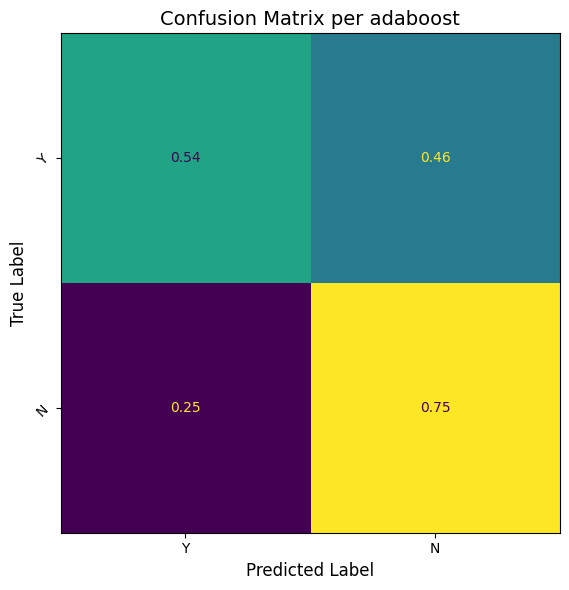

Classification report per svm:
              precision    recall  f1-score   support

         2.0       0.59      0.63      0.61     27698
         3.0       0.68      0.65      0.66     33976

    accuracy                           0.64     61674
   macro avg       0.64      0.64      0.64     61674
weighted avg       0.64      0.64      0.64     61674



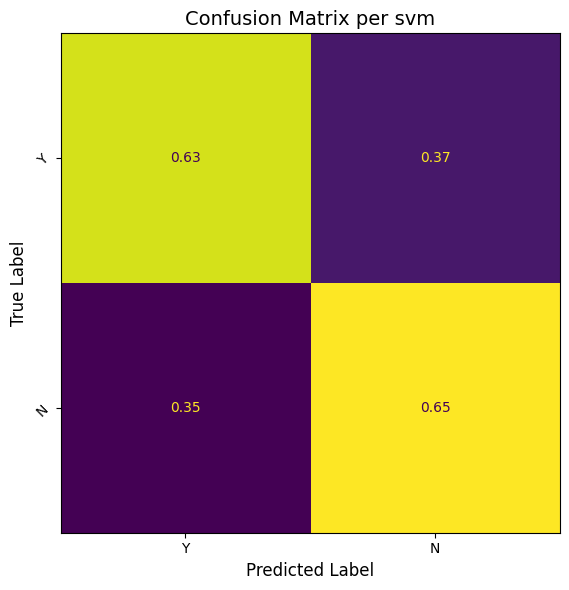

Classification report per knn:
              precision    recall  f1-score   support

         2.0       0.63      0.51      0.56     27698
         3.0       0.65      0.76      0.70     33976

    accuracy                           0.65     61674
   macro avg       0.64      0.63      0.63     61674
weighted avg       0.64      0.65      0.64     61674



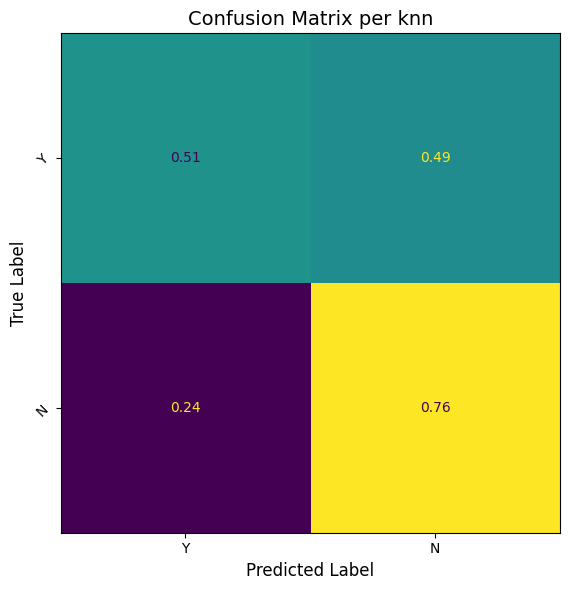

In [16]:
for name, pipeline in pipelines.items():
    y_pred_drink = pipeline.predict(X_test_s)

    report_drink = classification_report(y_test_s, y_pred_drink)

    print(f"Classification report per {name}:")
    print(report_drink)

    plot_confusion_matrix(y_test_s, y_pred_drink, ["Y", "N"], f"Confusion Matrix per {name}")